# Vlerick Use Case : Optimizing Distribution Policies

> __Tip__: Below some descriptives of the `df`'s variables. Also, note that variables with a *Hist_* prefix are in fact the results of a historically chosen delivery policy.
> * Price: the materials' prices
> * Status: the materials' status
> * Current_month_forecast: the daily adapted forecast for the whole of the current month
> * Daily_forcast: the daily forecasted demand
> * *Hist_*method: the historically chosen method of distribution
> * *Hist_*activity: the shops' historical general sales activity
> * *Hist_*shop_stock: the historical stock in shops
> * *Hist_*supplier_stock: the historical stock in the warehouse
> * *Hist_*sales: the historical sales

Presenting Proximus Ada's use case for the Vlerick hackcathon - 2024/04

---

#Imports

Public

In [27]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import io
import sys
import glob
import copy
import warnings
import statistics
from datetime import timedelta
from sklearn.cluster import KMeans

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# Data

Reading basetable

In [ ]:
#df = pd.read_pickle('/content/drive/MyDrive/Hackathons/Vlerick/vlerick.pkl')
dfa = pd.read_pickle('/content/vlerick.pkl')
dfa

In [30]:
df = dfa.reset_index()
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Material,Plant,Date,Description,Type,Supply,Demand,Price,Status,Current_month_forecast,Daily_forecast,Hist_method,Hist_activity,Hist_shop_stock,Hist_supplier_stock,Hist_sales
0,62003310,B124,2023-09-12,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,363.0,0.0,29.99,Ready for Launch,250.0,0.10,NEVER,21.31,0.0,350.0,0
1,62003310,B124,2023-09-13,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.10,AUTO,14.04,0.0,350.0,0
2,62003310,B124,2023-09-14,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.04,2.0,150.0,0
3,62003310,B124,2023-09-15,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.73,2.0,150.0,0
4,62003310,B124,2023-09-16,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.73,2.0,150.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154174,64641022,T942,2024-03-25,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.04,AUTO,15.84,1.0,50.0,0
154175,64641022,T942,2024-03-26,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,15.80,1.0,47.0,0
154176,64641022,T942,2024-03-27,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,15.19,1.0,40.0,0
154177,64641022,T942,2024-03-28,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,14.73,1.0,39.0,0


In [31]:
df['Plant'].nunique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



88

In [32]:
df.columns

Index(['Material', 'Plant', 'Date', 'Description', 'Type', 'Supply', 'Demand',
       'Price', 'Status', 'Current_month_forecast', 'Daily_forecast',
       'Hist_method', 'Hist_activity', 'Hist_shop_stock',
       'Hist_supplier_stock', 'Hist_sales'],
      dtype='object')

In [33]:
#Get the unique combinations of 'Materials' and 'Description'
unique_combinations = df[['Material', 'Description']].drop_duplicates()
print(unique_combinations)


        Material                                        Description
0       62003310  DBramante recycled Magsafe cover Monaco - blac...
16784   64639795                              Doro 6060 Black/White
34364   64639981                   Samsung Galaxy A14 4G 64GB Black
52026   64639984              Samsung A34 5G 128GB Awesome Graphite
69674   64639988              Samsung A54 5G 128GB Awesome Graphite
86861   64640000                      Px Apple iPhone 12 64GB Black
104543  64640153                           iPhone 14 128GB Midnight
122225  64640219                              iPhone 15 128GB Black
138448  64641022                         Xiaomi 13T Pro 512GB Black


In [34]:
# Create a dictionary mapping material numbers to item names
item_names = {
    62003310: "Black Cover",
    64639795: "Doro 6060 Black/White",
    64639981: "Samsung Galaxy A14",
    64639984: "Samsung A34",
    64639988: "Samsung A54",
    64640000: "iPhone 12",
    64640153: "iPhone 14",
    64640219: "iPhone 15",
    64641022: "Xiaomi 13T"
}

# Assuming 'df' has a 'Material' column with numeric IDs
df['Item'] = df['Material'].map(item_names)

# Handle potential missing values (if 'Material' has values not in 'item_names')
df['Item'] = df['Material'].map(item_names).fillna("Unknown")
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Material,Plant,Date,Description,Type,Supply,Demand,Price,Status,Current_month_forecast,Daily_forecast,Hist_method,Hist_activity,Hist_shop_stock,Hist_supplier_stock,Hist_sales,Item
0,62003310,B124,2023-09-12,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,363.0,0.0,29.99,Ready for Launch,250.0,0.10,NEVER,21.31,0.0,350.0,0,Black Cover
1,62003310,B124,2023-09-13,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.10,AUTO,14.04,0.0,350.0,0,Black Cover
2,62003310,B124,2023-09-14,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.04,2.0,150.0,0,Black Cover
3,62003310,B124,2023-09-15,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.73,2.0,150.0,0,Black Cover
4,62003310,B124,2023-09-16,DBramante recycled Magsafe cover Monaco - blac...,Accessories A&C,0.0,0.0,29.99,Ready for Launch,250.0,0.11,AUTO,14.73,2.0,150.0,0,Black Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154174,64641022,T942,2024-03-25,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.04,AUTO,15.84,1.0,50.0,0,Xiaomi 13T
154175,64641022,T942,2024-03-26,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,15.80,1.0,47.0,0,Xiaomi 13T
154176,64641022,T942,2024-03-27,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,15.19,1.0,40.0,0,Xiaomi 13T
154177,64641022,T942,2024-03-28,Xiaomi 13T Pro 512GB Black,Mobile,0.0,0.0,799.99,Maturity,100.0,0.03,AUTO,14.73,1.0,39.0,0,Xiaomi 13T


In [35]:
df['Item'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['Black Cover', 'Doro 6060 Black/White', 'Samsung Galaxy A14',
       'Samsung A34', 'Samsung A54', 'iPhone 12', 'iPhone 14',
       'iPhone 15', 'Xiaomi 13T'], dtype=object)

#Exploratory Data Analysis



##Product Level View

###Monthly Demand by Product & Status

<ipython-input-36-e40debdbf68f>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



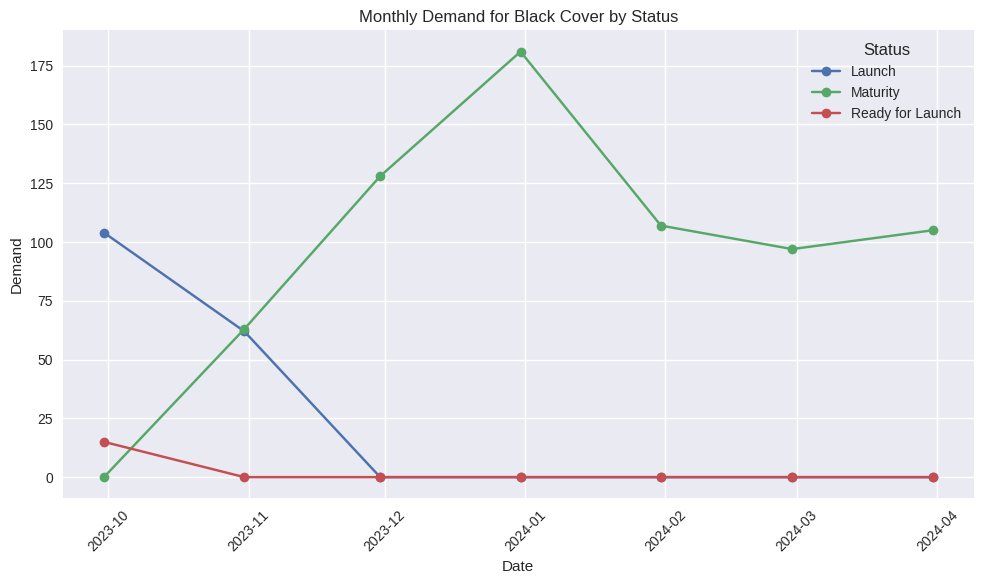

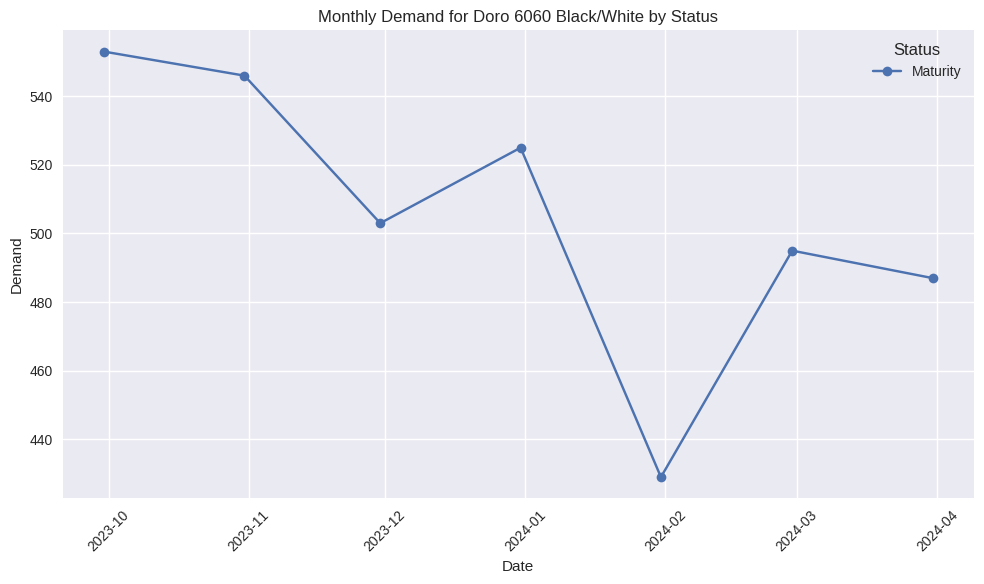

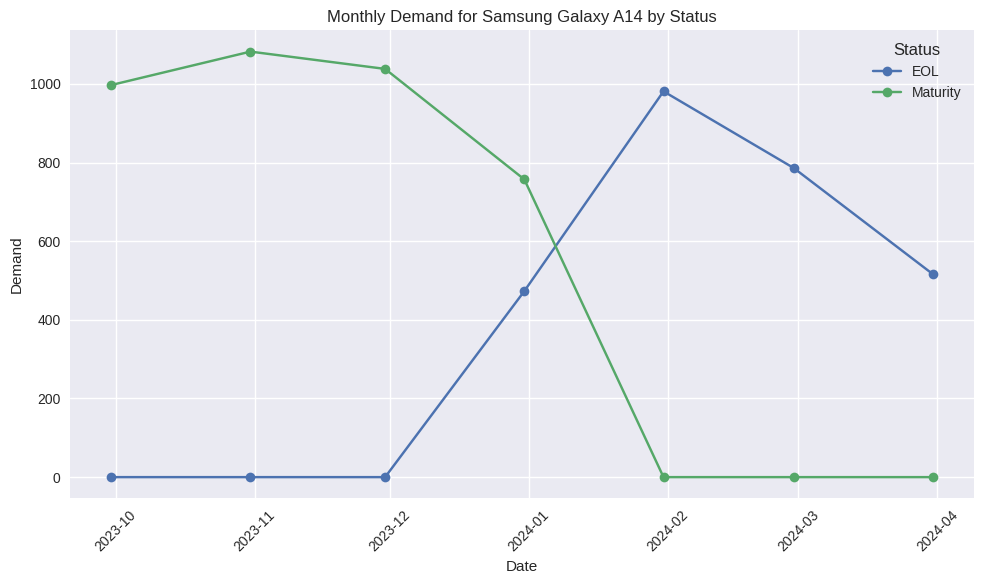

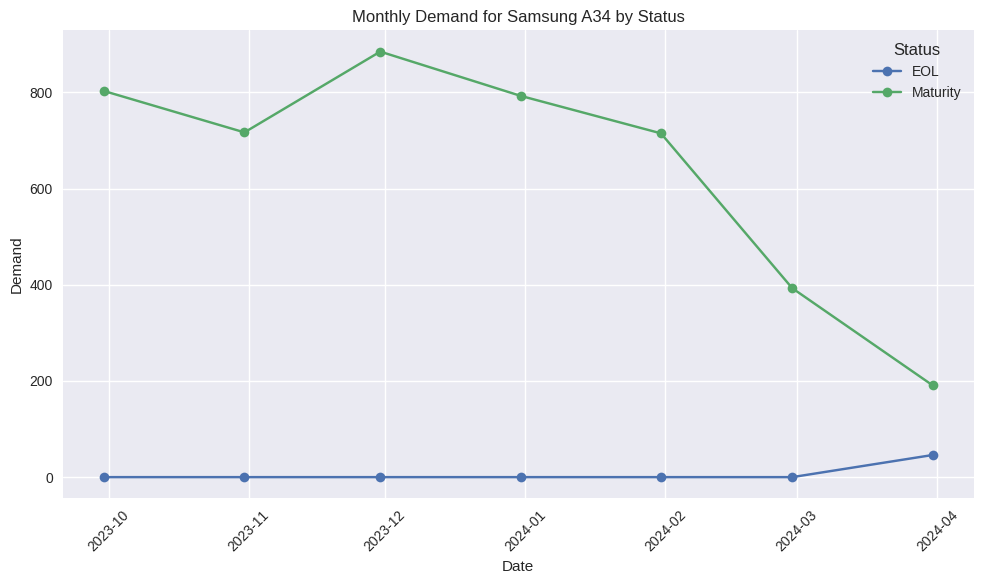

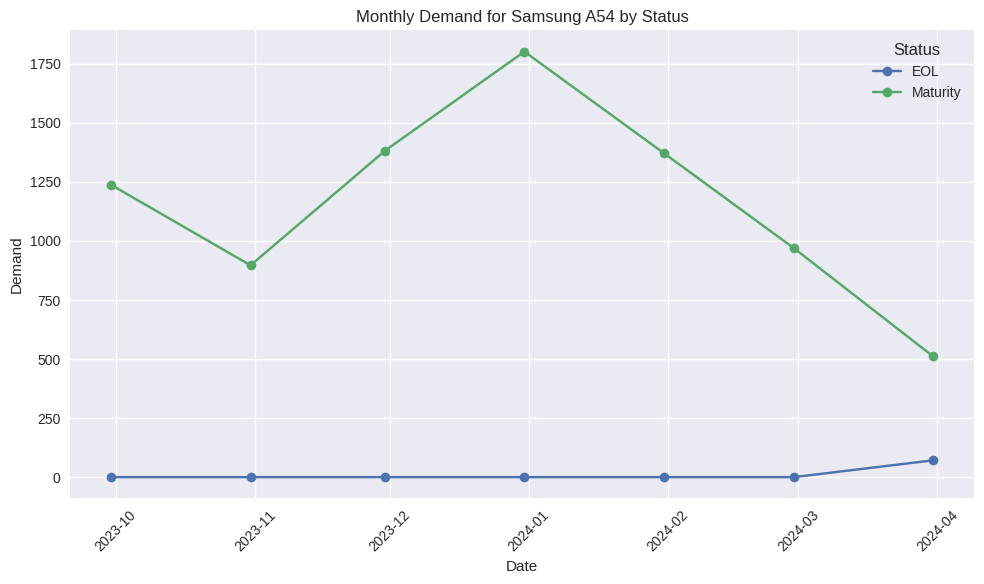

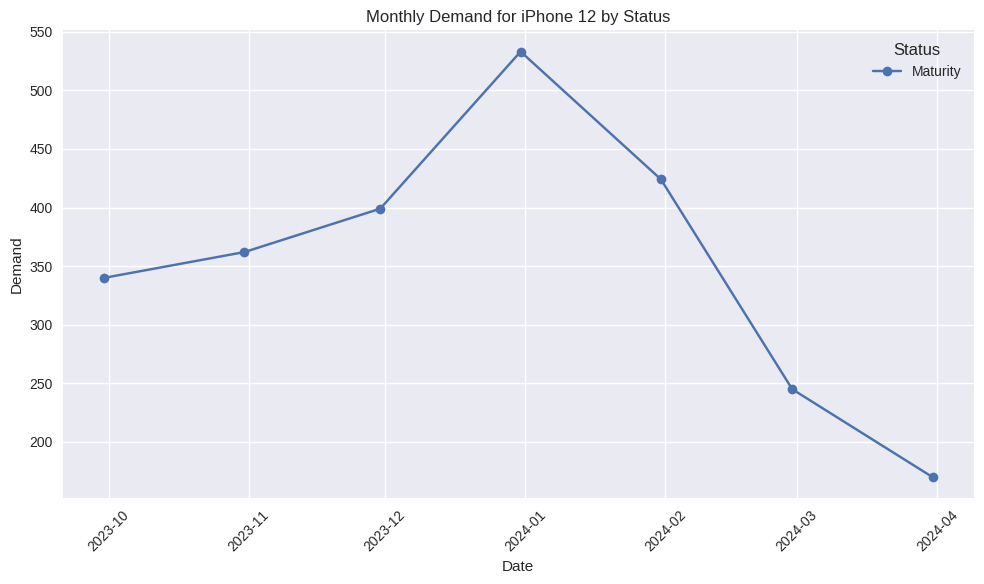

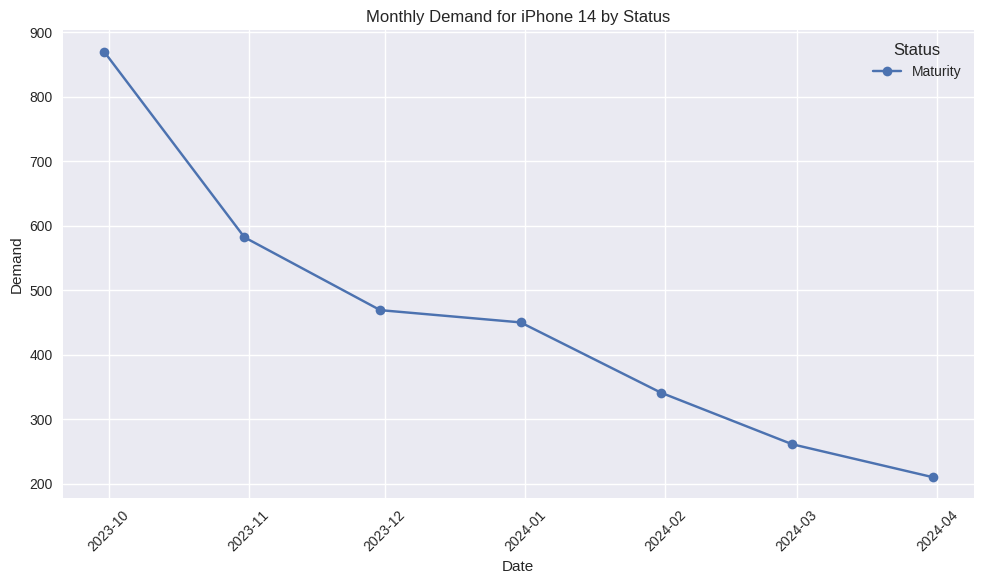

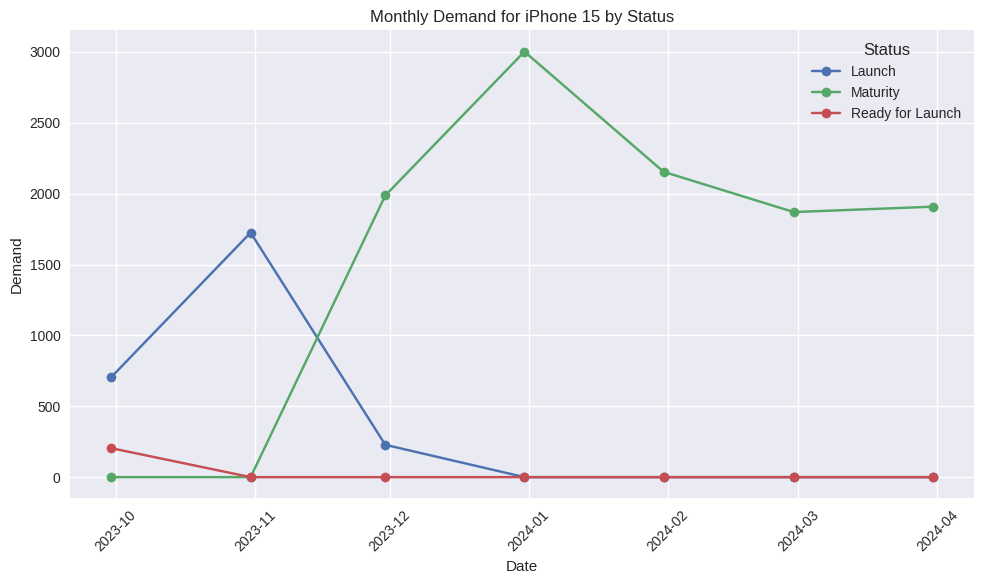

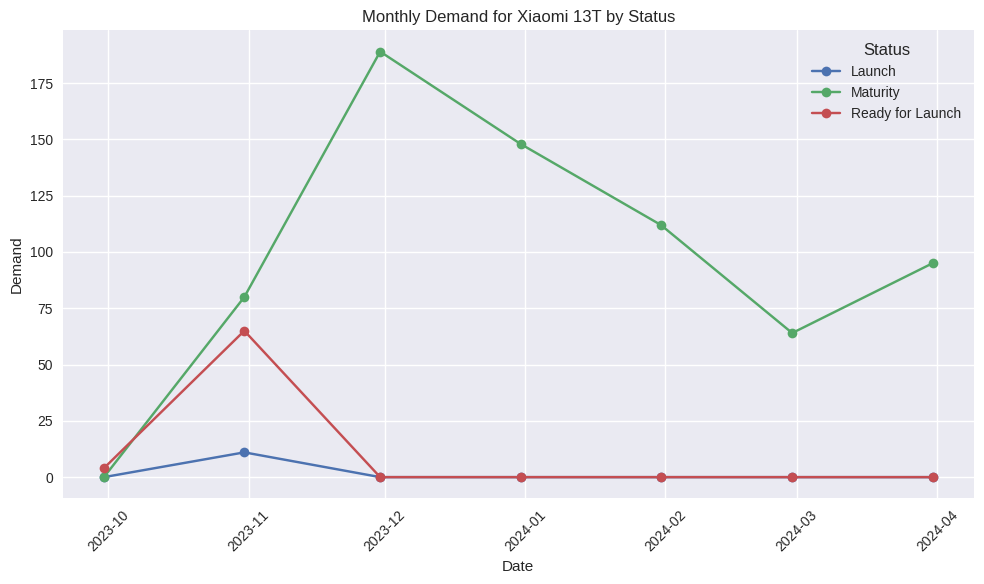

In [36]:
plt.style.use('seaborn')
import pandas as pd
import matplotlib.pyplot as plt

# Get unique items in the 'Item' column
unique_items = df['Item'].unique()

# Loop through each unique item
for item in unique_items:
    # Filter the DataFrame for the current item
    material_df = df[df['Item'] == item]

    # Group the data by both 'Date' and 'Status' and sum the 'Demand'
    grouped_data = material_df.groupby(['Date', 'Status'])['Demand'].sum().reset_index()

    # Pivot the data to have 'Status' as columns
    pivot_data = grouped_data.pivot(index='Date', columns='Status', values='Demand')

    # Aggregate the data on a monthly basis
    monthly_demand = pivot_data.resample('M').sum()

    # Plot the data for each status with a different color
    plt.figure(figsize=(10, 6))
    for status in monthly_demand.columns:
        plt.plot(monthly_demand.index, monthly_demand[status], marker='o', linestyle='-', label=status)

    plt.title(f'Monthly Demand for {item} by Status')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Status')
    plt.tight_layout()
    plt.show()

###Total Demand by Day of the Week

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



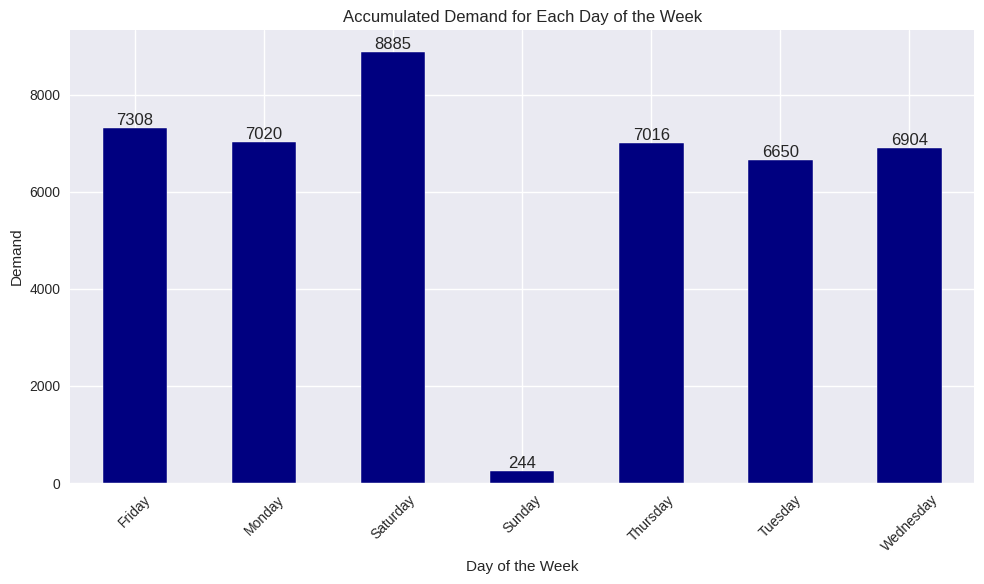

In [37]:
# Extract day of the week from the date
df['Day_of_Week'] = df['Date'].dt.day_name()

# Group by day of the week and sum the demand for all materials
daily_demand = df.groupby('Day_of_Week')['Demand'].sum()

# Plotting the histogram with data labels
plt.figure(figsize=(10, 6))
bars = daily_demand.plot(kind='bar', color='navy')

plt.title('Accumulated Demand for Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding data labels to the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom')

plt.show()

###Total Volume by Product

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-38-1bc0a63ebdf6>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-38-1bc0a63ebdf6>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




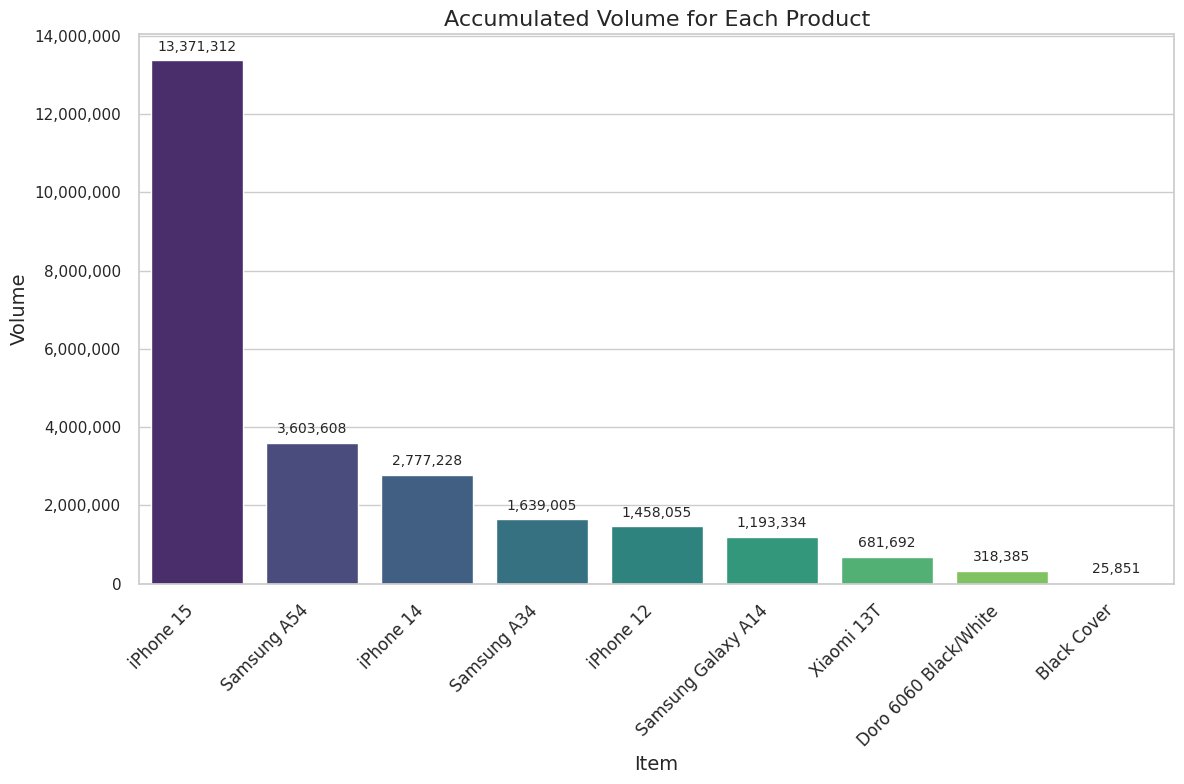

In [38]:
plt.style.use('seaborn')
import seaborn as sns
import matplotlib.ticker as ticker  # Import ticker for formatting ticks

# Calculate 'Volume' by multiplying 'Demand' with 'Price'
df['Volume'] = df['Demand'] * df['Price']

# Group by 'Material' and sum the 'Volume'
material_demand = df.groupby('Item')['Volume'].sum()

# Sort materials based on demand in descending order
sorted_materials = material_demand.sort_values(ascending=False)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting the bar chart
plt.figure(figsize=(12, 8))  # Increase figure size for better visualization
ax = sns.barplot(x=sorted_materials.index, y=sorted_materials.values, palette="viridis")  # Use seaborn barplot for enhanced aesthetics

# Add labels and title
plt.title('Accumulated Volume for Each Product', fontsize=16)
plt.xlabel('Item', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability

# Add data labels with rounding and commas
for p in ax.patches:
    volume = p.get_height()
    ax.annotate('{:,.0f}'.format(volume),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10)

# Format y-axis ticks with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


###Monthly Demand by Product

In [ ]:
plt.style.use('seaborn')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



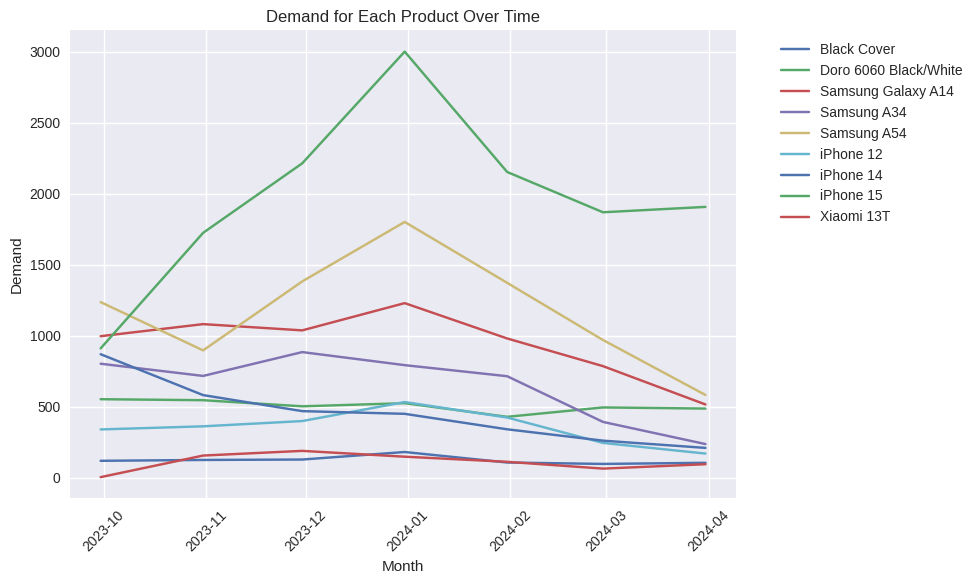

In [40]:
# Group by 'Material' and 'Date', and sum the 'Demand'
item_demand = df.groupby(['Item', pd.Grouper(key='Date', freq='M')])['Demand'].sum()

# Get unique Items
items = df['Item'].unique()

# Plot line chart for each material
plt.figure(figsize=(10, 6))
for item in items:
    item_data = item_demand[item]
    plt.plot(item_data.index, item_data.values, label=item)

plt.title('Demand for Each Product Over Time')
plt.xlabel('Month')
plt.ylabel('Demand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Shop Level View

###Top & Bottom 10 Shops by Demand

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-41-f370cfe08efc>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



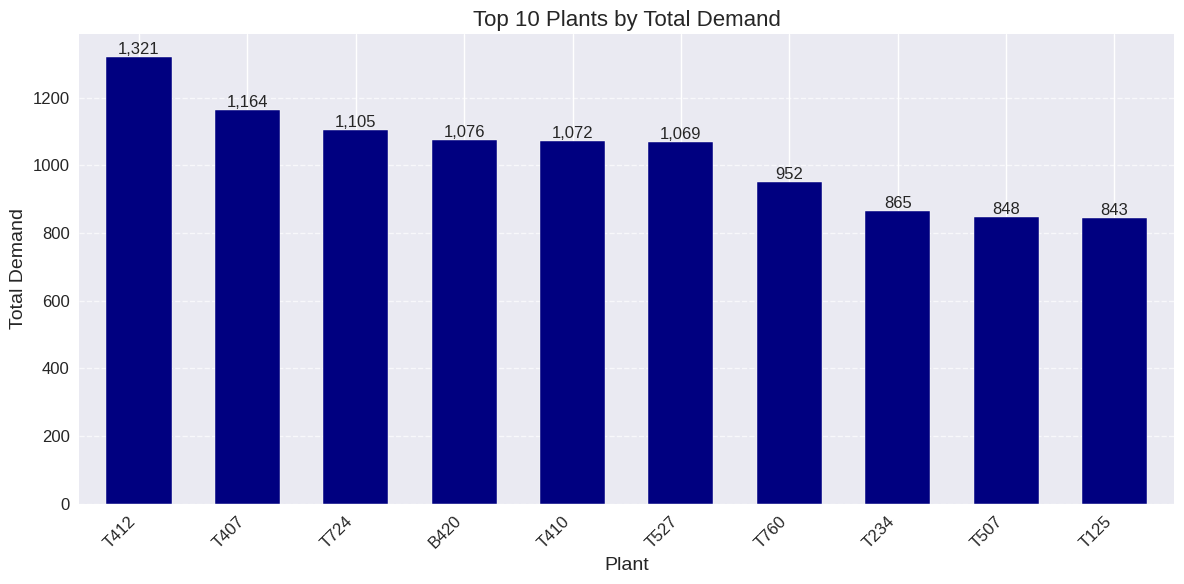

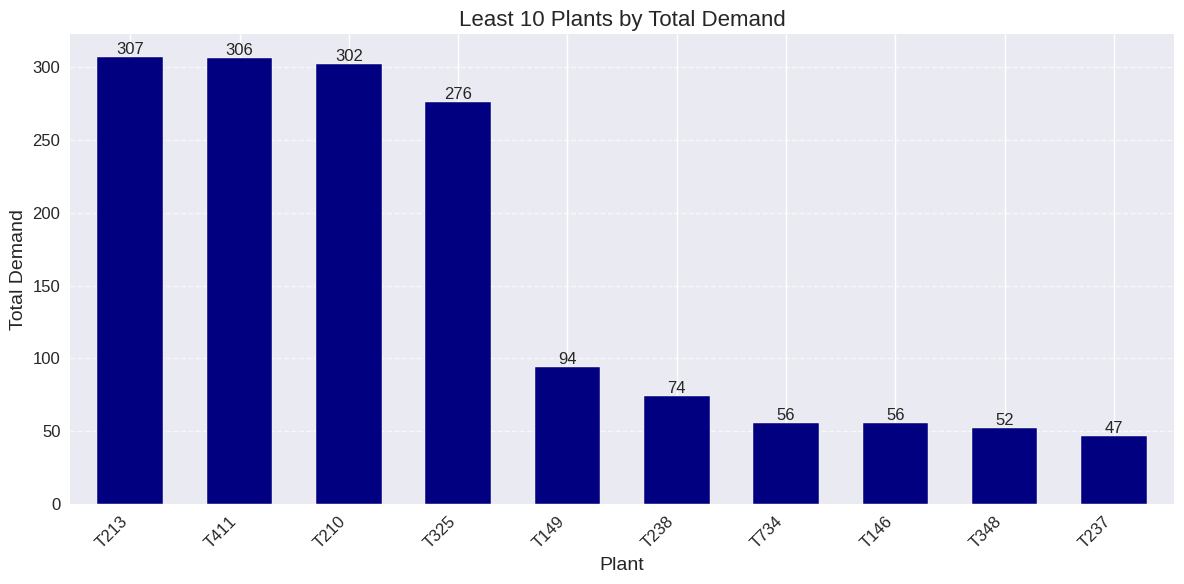

In [41]:
plt.style.use('seaborn')

# Group by 'Plant' and sum the 'Demand'
plant_demand = df.groupby('Plant')['Demand'].sum()

# Sort plants based on demand in descending order
sorted_plants = plant_demand.sort_values(ascending=False)

# Get top 10 and least 10 plants
top_10_plants = sorted_plants.head(10)
least_10_plants = sorted_plants.tail(10)

# Set common style parameters
plt.rcParams.update({'font.size': 12})

# Plotting the top 10 plants
plt.figure(figsize=(12, 6))
top_bars = top_10_plants.plot(kind='bar', color='navy', width=0.6)

plt.title('Top 10 Plants by Total Demand', fontsize=16)
plt.xlabel('Plant', fontsize=14)
plt.ylabel('Total Demand', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of the bars
for bar in top_bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Plotting the least 10 plants
plt.figure(figsize=(12, 6))
least_bars = least_10_plants.plot(kind='bar', color='navy', width=0.6)

plt.title('Least 10 Plants by Total Demand', fontsize=16)
plt.xlabel('Plant', fontsize=14)
plt.ylabel('Total Demand', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of the bars
for bar in least_bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
plt.style.use('seaborn')

###Top & Bottom Shop Demand over Time

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



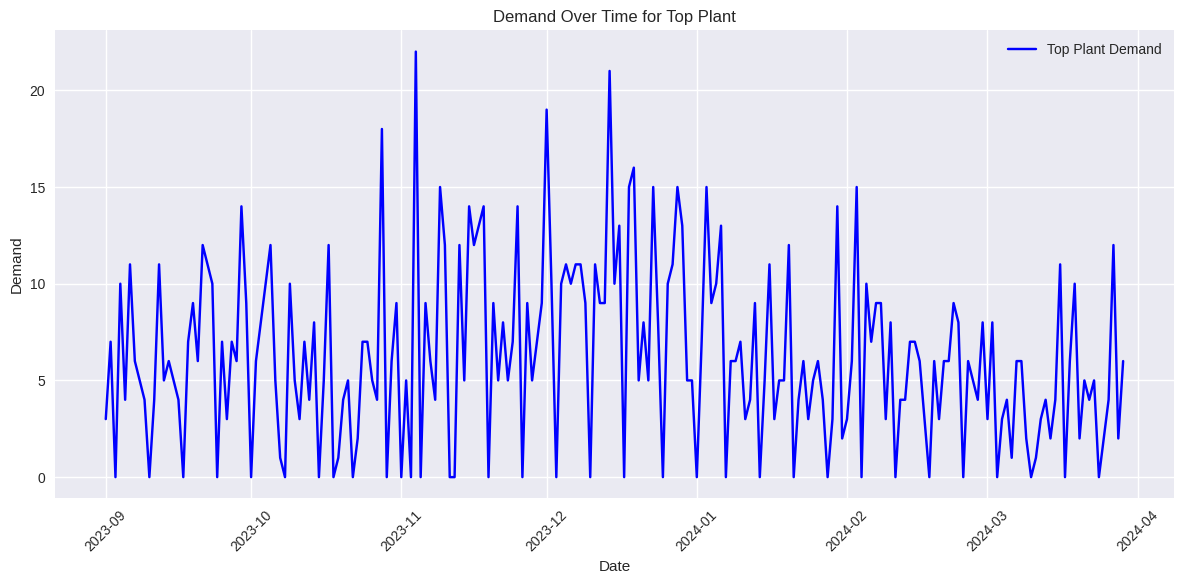

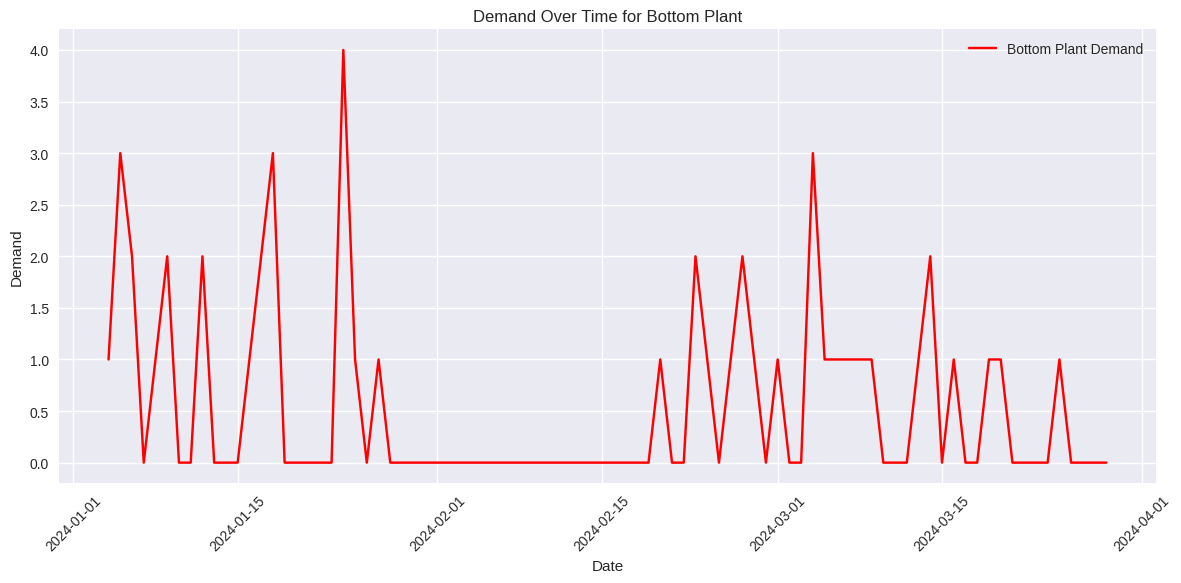

In [43]:
import matplotlib.pyplot as plt

# Group by 'Plant' and sum the 'Demand'
plant_demand = df.groupby('Plant')['Demand'].sum()

# Sort plants based on demand in descending order
sorted_plants = plant_demand.sort_values(ascending=False)

# Select top and bottom plant
top_plant = sorted_plants.head(1)
bottom_plant = sorted_plants.tail(1)

# Filter the DataFrame for top and bottom plant
top_df = df[df['Plant'].isin(top_plant.index)]
bottom_df = df[df['Plant'].isin(bottom_plant.index)]

# Aggregate demand over time for top and bottom plant
top_agg_demand = top_df.groupby('Date')['Demand'].sum()
bottom_agg_demand = bottom_df.groupby('Date')['Demand'].sum()

# Plot aggregated demand over time for top plant
plt.figure(figsize=(12, 6))
plt.plot(top_agg_demand.index, top_agg_demand.values, label='Top Plant Demand', color='blue')
plt.title('Demand Over Time for Top Plant')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot aggregated demand over time for bottom plant
plt.figure(figsize=(12, 6))
plt.plot(bottom_agg_demand.index, bottom_agg_demand.values, label='Bottom Plant Demand', color='red')
plt.title('Demand Over Time for Bottom Plant')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Number of Products per Shop

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



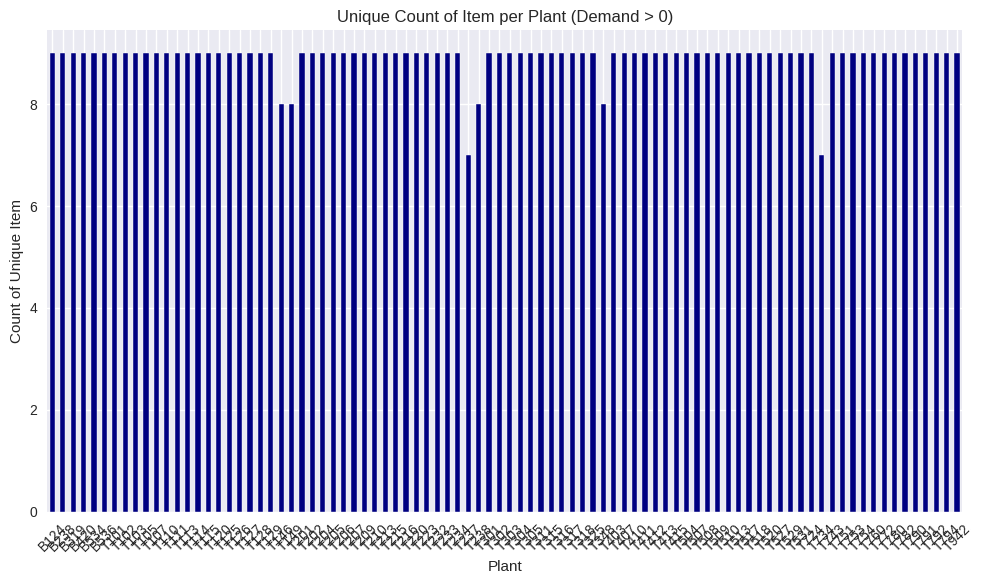

In [44]:
# Filter the DataFrame to include only rows where 'Demand' is greater than 0
filtered_df = df[df['Demand'] > 0]

# Group by 'Plant' and count unique 'Material'
material_per_plant_with_demand = filtered_df.groupby('Plant')['Item'].nunique()

plt.figure(figsize=(10, 6))
material_per_plant_with_demand.plot(kind='bar', color='navy')

plt.title('Unique Count of Item per Plant (Demand > 0)')
plt.xlabel('Plant')
plt.ylabel('Count of Unique Item')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
# Group by 'Plant' and 'Material', and sum the 'Demand'
demand_sum_per_plant_material = df.groupby(['Plant', 'Item'])['Demand'].sum()

# Filter out combinations where the sum of 'Demand' is zero
zero_demand_combinations = demand_sum_per_plant_material[demand_sum_per_plant_material == 0]

# Reset the index to get a DataFrame with 'Plant' and 'Material' columns
result_df = zero_demand_combinations.reset_index()

# Print the result
print(result_df)


  Plant         Item  Demand
0  T146  Black Cover     0.0
1  T149  Black Cover     0.0
2  T237  Black Cover     0.0
3  T237    iPhone 12     0.0
4  T238  Black Cover     0.0
5  T348   Xiaomi 13T     0.0
6  T734   Xiaomi 13T     0.0
7  T734    iPhone 12     0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##Product x Shop Level View

###Product by Shop - Demand Heatmap


In [46]:
dfa['Volume'] = dfa['Demand'] * dfa['Price']
df_date = dfa.reset_index(level=2)
df_pivot = df_date.pivot_table(index='Plant', columns=['Material'], values='Volume', aggfunc='sum')
df_pivot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Material,62003310,64639795,64639981,64639984,64639988,64640000,64640153,64640219,64641022
Plant,,,,,,,,,
B124,89.97,2429.73,8279.54,9889.73,32649.25,20289.66,20929.76,96999.00,3399.96
B238,359.88,2159.76,13679.24,24439.32,74618.30,19729.67,24359.72,192058.02,7099.92
B319,569.81,809.91,7379.59,7899.78,24419.44,16889.71,47029.46,226007.67,16099.82
B420,629.79,6029.33,21058.83,19689.45,100247.71,43679.27,72959.17,395755.92,20099.77
B534,299.90,3689.59,12599.30,24879.32,36859.16,20349.65,30869.64,108638.88,13199.85
...,...,...,...,...,...,...,...,...,...
T790,209.93,899.90,3779.79,15679.56,33749.23,1829.97,42379.51,111548.85,2699.97
T791,149.95,809.91,7919.56,10119.72,23559.46,20389.66,29779.66,136768.59,11499.87
T792,419.86,269.97,14399.20,12999.64,43449.01,28949.50,88338.98,365686.23,14299.84


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



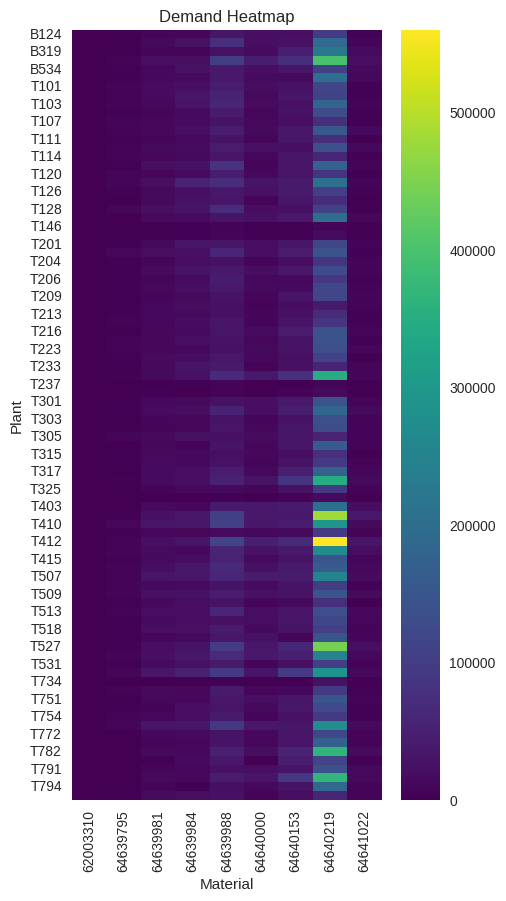

In [47]:
plt.figure(figsize=(5,10))
sns.heatmap(df_pivot, cmap='viridis')  # Create the heatmap using the 'coolwarm' colormap
plt.title('Demand Heatmap')  # Set the title of the heatmap
plt.xlabel('Material')  # Set the label for the x-axis
plt.ylabel('Plant')  # Set the label for the y-axis
plt.show()  # Show the heatmap

###Product by Shop Treemap

In [48]:
# Assuming 'df' has a 'Material' column with numeric IDs
df['Item'] = df['Material'].map(item_names)

# Handle potential missing values (if 'Material' has values not in 'item_names')
df['Item'] = df['Material'].map(item_names).fillna("Unknown")

import plotly.express as px

# df = px.data.tips()

fig = px.treemap(df, path=['Item', 'Plant'],
                 values='Demand')

# Enlarging the figure size
fig.update_layout(width=1000, height=600)

fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

